In [1]:
!pip install uv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 25.2 MB/s eta 0:00:00


In [2]:
!uv pip install torch torchvision -q

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
import torch

МАСКА ИСКЛЮЧЕНИЯ ИЗ ВНИМАНИЯ БАННЕРОВ

In [5]:
def create_text_mask_by_location(image):
    h, w = image.shape[:2]
    # Создаем пустую маску (255 - область интереса, 0 - текст/баннеры)
    text_mask = np.ones((h, w), dtype=np.uint8) * 255

    # Координаты баннеров (исправленные на основе предположений)
    # Первый баннер: [45, 474] (x1, y1) и [334, 524] (x2, y2)
    x1, y1 = min(45, 334), min(474, 524)  # Верхний левый угол
    x2, y2 = max(45, 334), max(474, 524)  # Нижний правый угол
    text_mask[y1:y2, x1:x2] = 0

    # Второй баннер: [879, 2] (x1, y1) и [1072, 50] (x2, y2)
    x1, y1 = min(879, 1072), min(2, 50)  # Верхний левый угол
    x2, y2 = max(879, 1072), max(2, 50)  # Нижний правый угол
    text_mask[y1:y2, x1:x2] = 0


# Преобразование исходного изображения в HSV для создания маски фона
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Диапазоны для синего фона (настройте под ваш кадр)
    lower_blue = np.array([100, 200, 150])  # Уточненный диапазон для синего
    upper_blue = np.array([130, 255, 255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    # Инвертируем маску фона (0 - синий фон, 255 - остальное)
    mask_blue = cv2.bitwise_not(mask_blue)

    # Объединяем маску баннеров и маску фона
    final_mask = cv2.bitwise_and(text_mask, mask_blue)

    print("Маска фона (0 - синий фон, 255 - остальное):")
    cv2_imshow(mask_blue)
    print("Итоговая маска (баннеры + фон):")
    cv2_imshow(final_mask)

    return final_mask



МАСКА ДЛЯ ЛЮДЕЙ

In [6]:
def create_people_mask(image, unet_model):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = torch.tensor(image_rgb).permute(2, 0, 1).unsqueeze(0).float()

    with torch.no_grad():
        mask = unet_model(input_tensor).sigmoid().squeeze().numpy()
    mask = (mask > 0.5).astype(np.uint8) * 255

    # Постобработка
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    print("Маска для людей:")
    cv2_imshow(mask)
    return mask

МАСКА ДЛЯ "ДОМА"

In [7]:
# Новая функция для создания маски "дома"
def create_house_mask(image, text_mask):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Диапазон для "дома"
    lower_house = np.array([110, 50, 75])
    upper_house = np.array([120, 180, 160])

    mask_house = cv2.inRange(hsv, lower_house, upper_house)

    # Применяем маску баннеров, чтобы исключить текст
    mask_house = cv2.bitwise_and(mask_house, mask_house, mask=text_mask)

    # Морфологические операции для улучшения маски
    kernel = np.ones((5, 5), np.uint8)
    mask_house = cv2.morphologyEx(mask_house, cv2.MORPH_OPEN, kernel)  # Удаление шума
    mask_house = cv2.morphologyEx(mask_house, cv2.MORPH_CLOSE, kernel)  # Заполнение разрывов

    print("Маска для дома:")
    cv2_imshow(mask_house)

    # Поиск контуров "дома"
    contours_house, _ = cv2.findContours(mask_house, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Фильтрация контуров по площади
    filtered_contours_house = [cnt for cnt in contours_house if cv2.contourArea(cnt) > 20000]

    return mask_house, filtered_contours_house

МАСКА ДЛЯ КАМНЕЙ (ЖЁЛТЫХ И КРАСНЫХ)

In [14]:
def find_contours_of_cards(image, text_mask):
    # Применяем маску текста, чтобы исключить баннеры
    image_masked = cv2.bitwise_and(image, image, mask=text_mask)

    # Преобразование в HSV для камней
    hsv = cv2.cvtColor(image_masked, cv2.COLOR_BGR2HSV)

    # Диапазоны для желтых камней
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Диапазоны для красных камней (два диапазона, так как красный цвет в HSV делится на два участка)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 230, 230])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([180, 230, 230])
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask_red1, mask_red2)

# Применяем маску текста к каждой цветной маске
    mask_yellow = cv2.bitwise_and(mask_yellow, mask_yellow, mask=text_mask)
    mask_red = cv2.bitwise_and(mask_red, mask_red, mask=text_mask)

    # Морфологические операции для очистки масок
    kernel = np.ones((5, 5), np.uint8)
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_OPEN, kernel)
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, kernel)
    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel)
    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel)

    # Поиск контуров для желтых камней
    contours_yellow, _ = cv2.findContours(mask_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours_yellow = [cnt for cnt in contours_yellow if 100 < cv2.contourArea(cnt) < 600]

    # Поиск контуров для красных камней
    contours_red, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours_red = [cnt for cnt in contours_red if 100 < cv2.contourArea(cnt) < 600]

    def filter_circles(contours, mask):
        confirmed_contours = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            roi = mask[y:y+h, x:x+w]
            if roi.shape[0] == 0 or roi.shape[1] == 0:
                continue

            # Улучшенные параметры HoughCircles
            circles = cv2.HoughCircles(
                cv2.cvtColor(image_masked[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY),
                cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                param1=50, param2=15, minRadius=8, maxRadius=40
            )

            if circles is not None:
                circles = np.round(circles[0, :]).astype("int")
                # Проверяем, соответствует ли круг размеру контура
                for (cx, cy, r) in circles:
                    if abs(r - w/2) < 10 and abs(r - h/2) < 10:  # Проверка на близость к круглой форме
                        confirmed_contours.append(cnt)
                        break
        return confirmed_contours

    # Фильтруем контуры с помощью HoughCircles
    confirmed_yellow = filter_circles(filtered_contours_yellow, mask_yellow)
    confirmed_red = filter_circles(filtered_contours_red, mask_red)

    return confirmed_yellow, confirmed_red, mask_yellow, mask_red

СОЗДАНИЕ АННОТАЦИИ

In [15]:
# Функция создания аннотации
def create_yolo_annotations(contours_yellow, contours_red, contours_house, frame_number, image_shape, output_dir="/content/drive/MyDrive/Sber_Test/1_Энд_Аннотации"):
    img_height, img_width = image_shape[:2]
    annotations_yolo = []
    class_map = {"yellow": 0, "red": 1, "house": 2}  # Добавляем класс для "дома"

    for cnt in contours_yellow:
        x, y, w, h = cv2.boundingRect(cnt)
        center_x = x + w // 2
        center_y = y + h // 2
        norm_center_x = center_x / img_width
        norm_center_y = center_y / img_height
        norm_width = w / img_width
        norm_height = h / img_height
        annotations_yolo.append(f"{class_map['yellow']} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}")

    for cnt in contours_red:
        x, y, w, h = cv2.boundingRect(cnt)
        center_x = x + w // 2
        center_y = y + h // 2
        norm_center_x = center_x / img_width
        norm_center_y = center_y / img_height
        norm_width = w / img_width
        norm_height = h / img_height
        annotations_yolo.append(f"{class_map['red']} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}")


    for cnt in contours_house:
        x, y, w, h = cv2.boundingRect(cnt)
        center_x = x + w // 2
        center_y = y + h // 2
        norm_center_x = center_x / img_width
        norm_center_y = center_y / img_height
        norm_width = w / img_width
        norm_height = h / img_height
        annotations_yolo.append(f"{class_map['house']} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    txt_output_path = os.path.join(output_dir, f"frame_{frame_number}.txt")
    with open(txt_output_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(annotations_yolo))
    print(f"YOLO TXT аннотации сохранены в: {txt_output_path}")

Тестовый кадр, Оригинал


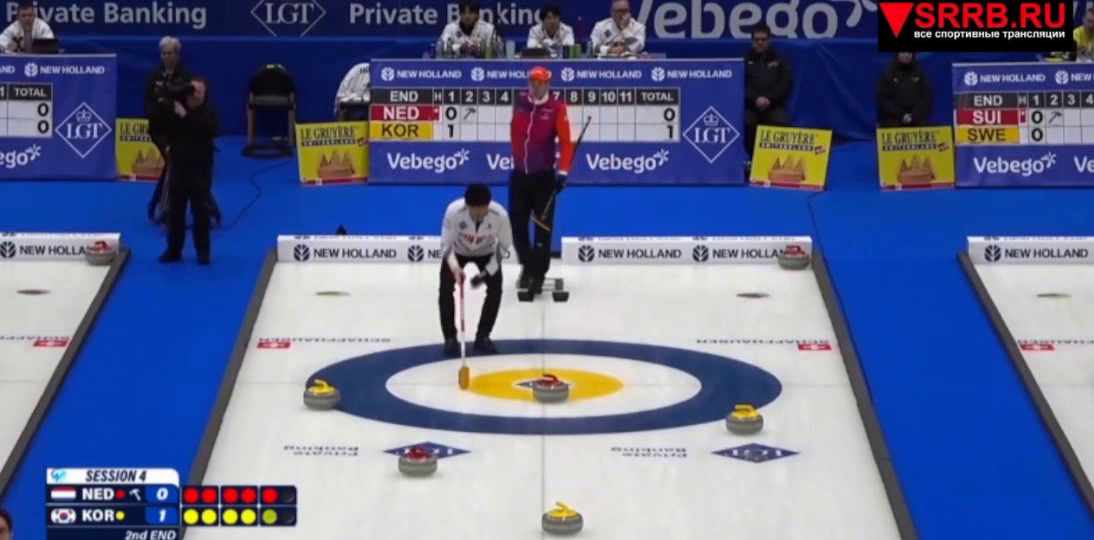

Маска фона (0 - синий фон, 255 - остальное):


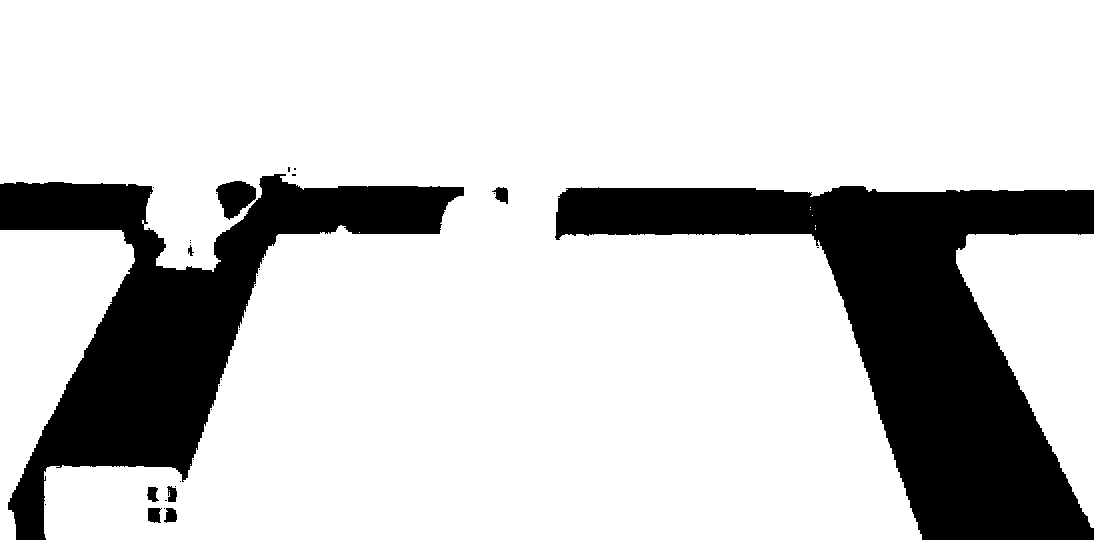

Итоговая маска (баннеры + фон):


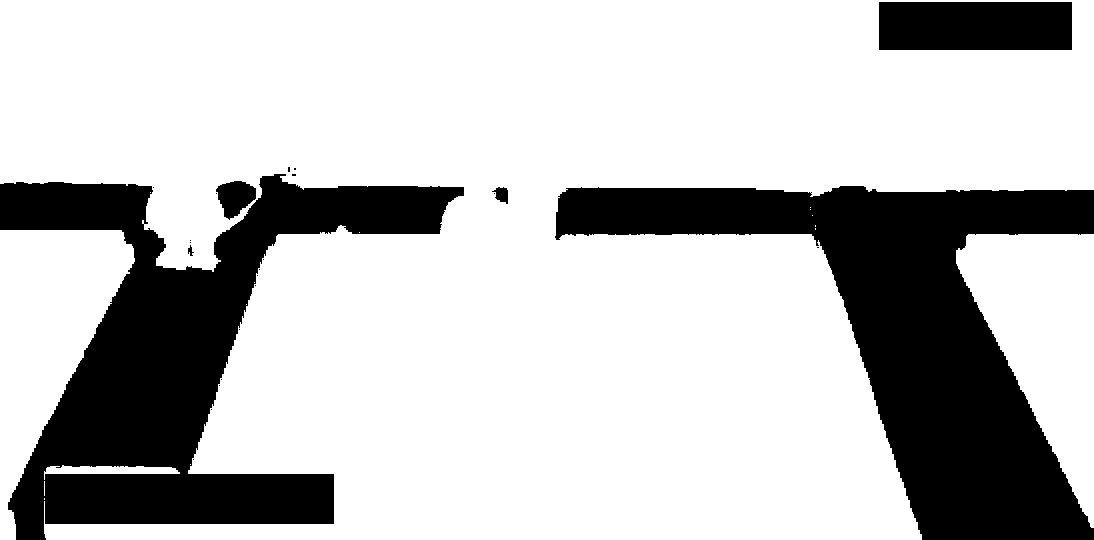

Маска баннеров


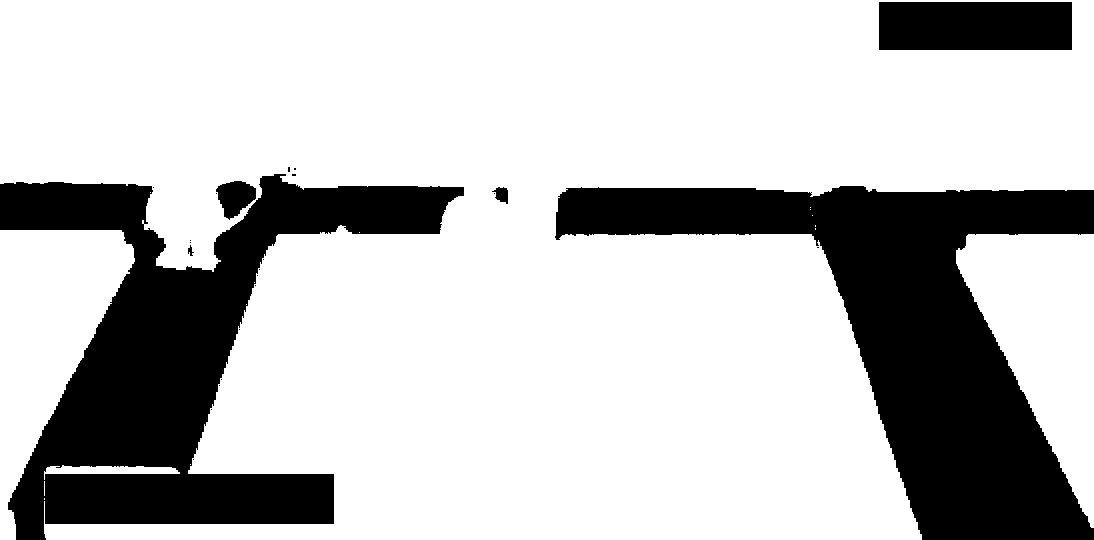

Маска для дома:


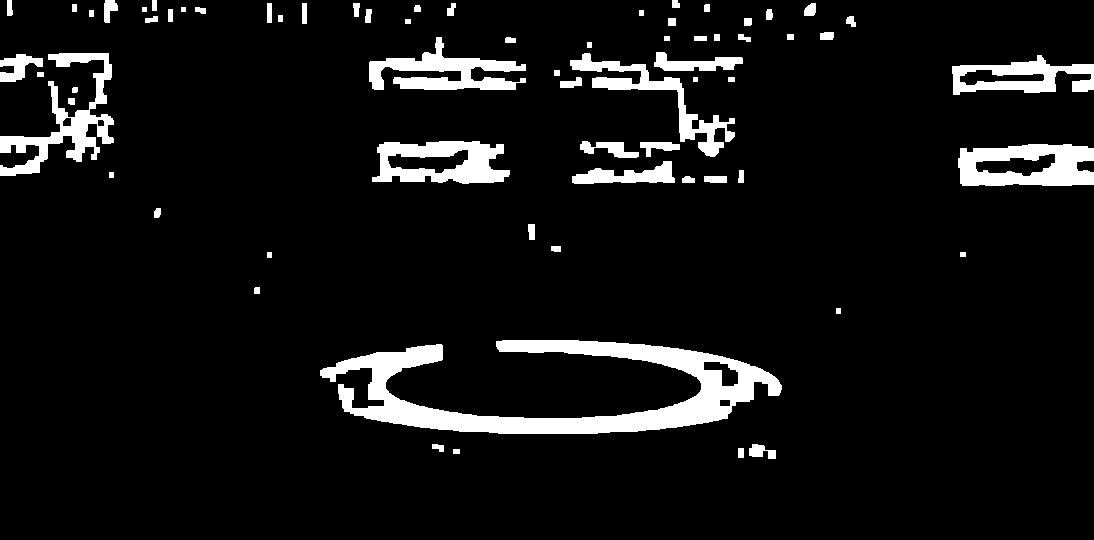

Количество желтых камней: 0
Количество красных камней: 0
Маска для желтых камней


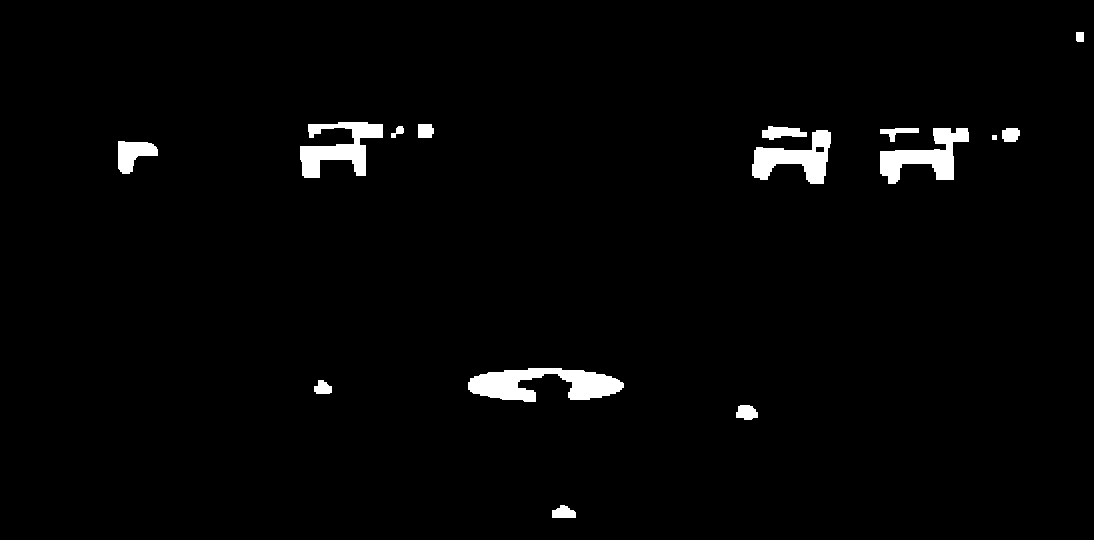

Маска для красных камней


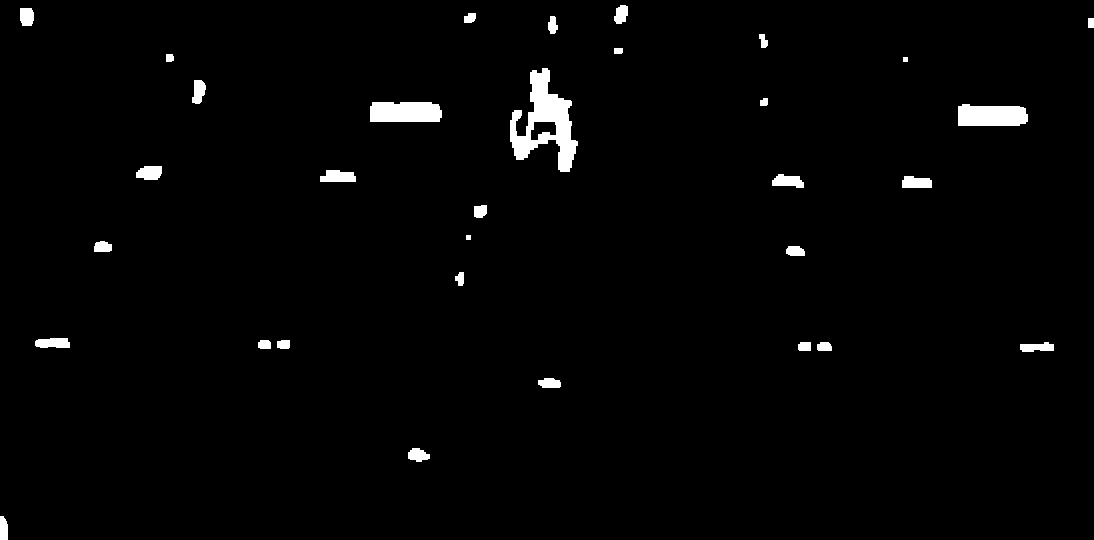

Итоговый кадр с контурами:


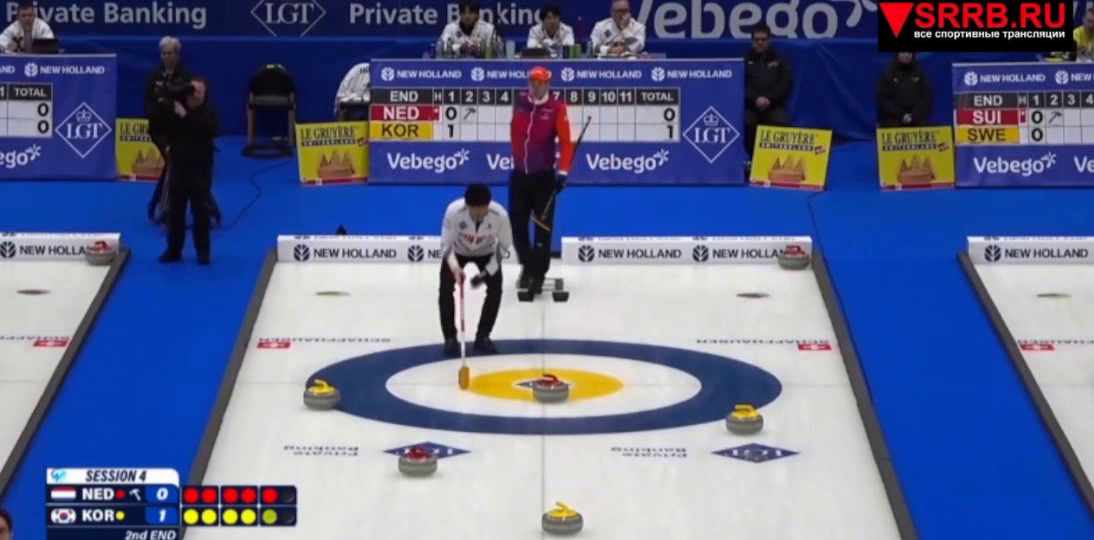

YOLO TXT аннотации сохранены в: /content/drive/MyDrive/Sber_Test/1_Энд_Аннотации/frame_2900.txt


In [18]:
# Собириаем функции
video_path = '/content/drive/MyDrive/Sber_Test/1_end.mp4'
cap = cv2.VideoCapture(video_path)
frame_number = 2900
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()

# Инференс модели U-Net

if ret:
    print("Тестовый кадр, Оригинал")
    cv2_imshow(frame)

    text_mask = create_text_mask_by_location(frame)
    print("Маска баннеров")
    cv2_imshow(text_mask)

    # Создание маски людей
    #people_mask = create_people_mask(frame, unet_model)

    #for_house_mask = cv2.bitwise_and(text_mask, cv2.bitwise_not(people_mask))
    #print("Маска баннеров+люди")
    #cv2_imshow(for_house_mask)

    # Создаем маску и контуры для "дома"
    mask_house, contours_house = create_house_mask(frame, text_mask)

    contours_yellow, contours_red, mask_yellow, mask_red = find_contours_of_cards(frame, text_mask)

    print(f"Количество желтых камней: {len(contours_yellow)}")
    for i, cnt in enumerate(contours_yellow):
        x, y, w, h = cv2.boundingRect(cnt)
        print(f"Желтый камень {i+1}: координаты центра (x, y) = ({x + w//2}, {y + h//2})")

    print(f"Количество красных камней: {len(contours_red)}")
    for i, cnt in enumerate(contours_red):
        x, y, w, h = cv2.boundingRect(cnt)
        print(f"Красный камень {i+1}: координаты центра (x, y) = ({x + w//2}, {y + h//2})")

    for i, cnt in enumerate(contours_house):
        x, y, w, h = cv2.boundingRect(cnt)
        print(f"Координаты центра дома (x, y) = ({x + w//2}, {y + h//2})")

    print("Маска для желтых камней")
    cv2_imshow(mask_yellow)
    print("Маска для красных камней")
    cv2_imshow(mask_red)

    contour_image = frame.copy()
    cv2.drawContours(contour_image, contours_yellow, -1, (0, 255, 255), 2)
    cv2.drawContours(contour_image, contours_red, -1, (0, 0, 255), 2)
    cv2.drawContours(contour_image, contours_house, -1, (255, 255, 255), 2)  # Белый цвет для "дома"
    print("Итоговый кадр с контурами:")
    cv2_imshow(contour_image)

    # Создаем YOLO аннотации, включая "дом"
    create_yolo_annotations(contours_yellow, contours_red, contours_house, frame_number, frame.shape)
else:
    print("Ошибка: не удалось извлечь кадр")

cap.release()


________________________________________________________________________________________________________________________________________________________________


________________________________________________________________________________________________________________________________________________________________


________________________________________________________________________________________________________________________________________________________________

ПЕРЕВОД ПИКСЕЛЬНЫХ КООРДИНАТ В ДЕКАРТОВЫ


In [12]:
# Функция для чтения YOLO-аннотаций
def read_yolo_annotations(file_path):
    stones = []
    house = None
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            norm_center_x = float(parts[1])
            norm_center_y = float(parts[2])
            norm_width = float(parts[3])
            norm_height = float(parts[4])
            if class_id in [0, 1]:  # Желтые (0) или красные (1) камни
                stones.append({
                    'class_id': class_id,
                    'norm_center_x': norm_center_x,
                    'norm_center_y': norm_center_y,
                    'norm_width': norm_width,
                    'norm_height': norm_height
                })
            elif class_id == 2:  # Дом
                house = {
                    'norm_center_x': norm_center_x,
                    'norm_center_y': norm_center_y,
                    'norm_width': norm_width,
                    'norm_height': norm_height
                }
    return stones, house

# Функция для перевода нормализованных координат в пиксельные
def norm_to_pixel_coords(norm_x, norm_y, img_width, img_height):
    pixel_x = norm_x * img_width
    pixel_y = norm_y * img_height
    return pixel_x, pixel_y

# Функция для вычисления матрицы гомографии
def compute_homography(house, img_width, img_height):
    # Нормализованные координаты дома
    norm_center_x = house['norm_center_x']
    norm_center_y = house['norm_center_y']
    norm_width = house['norm_width']
    norm_height = house['norm_height']

    # Пиксельные координаты центра и границ дома
    center_x, center_y = norm_to_pixel_coords(norm_center_x, norm_center_y, img_width, img_height)
    half_width = (norm_width * img_width) / 2
    half_height = (norm_height * img_height) / 2

    # Опорные точки в пикселях (пример: углы bounding box дома)
    pixel_points = np.array([
        [center_x - half_width, center_y - half_height],  # Верхний левый
        [center_x + half_width, center_y - half_height],  # Верхний правый
        [center_x + half_width, center_y + half_height],  # Нижний правый
        [center_x - half_width, center_y + half_height]   # Нижний левый
    ], dtype=np.float32)

    # Физические координаты (в см), предполагаем, что дом — круг радиусом 182.9 см
    house_radius_cm = 182.9
    real_points = np.array([
        [-house_radius_cm, -house_radius_cm],  # Верхний левый
        [house_radius_cm, -house_radius_cm],   # Верхний правый
        [house_radius_cm, house_radius_cm],    # Нижний правый
        [-house_radius_cm, house_radius_cm]    # Нижний левый
    ], dtype=np.float32)

    # Вычисление матрицы гомографии
    H, _ = cv2.findHomography(pixel_points, real_points)
    return H

# Функция для перевода пиксельных координат в физические (см)
def pixel_to_real_coords(pixel_points, H):
    pixel_points = np.array(pixel_points, dtype=np.float32)
    real_points = cv2.perspectiveTransform(pixel_points[None, :, :], H)
    return real_points[0]  # Возвращаем массив координат [[x1, y1], [x2, y2], ...]

# Функция для подсчета камней в доме и на линии хог
def count_stones_in_house_and_hog(real_coords, house_radius_cm=182.9, hog_line_y_cm=640, hog_tolerance_cm=2.5):
    stones_in_house = 0
    stones_on_hog = 0

    for x_cm, y_cm in real_coords:
        # Проверка, находится ли камень в доме (расстояние от центра <= радиус дома)
        distance = np.sqrt(x_cm**2 + y_cm**2)
        if distance <= house_radius_cm:
            stones_in_house += 1

        # Проверка, находится ли камень на линии хог (Y-координата в пределах допуска)
        if abs(y_cm - hog_line_y_cm) <= hog_tolerance_cm:
            stones_on_hog += 1

    return stones_in_house, stones_on_hog

# Основной процесс
def main(annotation_file, img_width=1094, img_height=540):
    # Чтение аннотаций
    stones, house = read_yolo_annotations(annotation_file)
    if not stones or not house:
        print("Ошибка: нет данных о камнях или доме")
        return

    # Извлечение пиксельных координат центров камней
    pixel_centers = []
    for stone in stones:
        pixel_x, pixel_y = norm_to_pixel_coords(
            stone['norm_center_x'], stone['norm_center_y'], img_width, img_height
        )
        pixel_centers.append([pixel_x, pixel_y])

    # Вычисление матрицы гомографии
    H = compute_homography(house, img_width, img_height)

    # Перевод пиксельных координат в физические
    real_coords = pixel_to_real_coords(pixel_centers, H)

    # Вывод физических координат
    print("Физические координаты центров камней (см):")
    for i, (x_cm, y_cm) in enumerate(real_coords):
        print(f"Камень {i+1} (класс {stones[i]['class_id']}): x={x_cm:.2f} см, y={y_cm:.2f} см")

    # Подсчет камней в доме и на линии хог
    stones_in_house, stones_on_hog = count_stones_in_house_and_hog(real_coords)
    print(f"\nКоличество камней в доме: {stones_in_house}")
    print(f"Количество камней на линии хог: {stones_on_hog}")

In [13]:
# Запуск
if __name__ == "__main__":
    annotation_file = "/content/drive/MyDrive/Sber_Test/1_Энд_Аннотации/frame_6920.txt"
    main(annotation_file)

Физические координаты центров камней (см):
Камень 1 (класс 0): x=194.79 см, y=-53.05 см
Камень 2 (класс 0): x=208.51 см, y=-166.61 см
Камень 3 (класс 0): x=-148.15 см, y=-175.92 см
Камень 4 (класс 0): x=-427.99 см, y=-289.48 см
Камень 5 (класс 0): x=-492.00 см, y=-309.95 см
Камень 6 (класс 1): x=174.67 см, y=89.36 см
Камень 7 (класс 1): x=-452.68 см, y=-13.96 см
Камень 8 (класс 1): x=406.04 см, y=-228.04 см

Количество камней в доме: 0
Количество камней на линии хог: 0
